In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from random import randint
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import plotting_funcs as pf
import clustering_model as cm
import config as conf

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from keras.callbacks import EarlyStopping

In [2]:
X = np.load('x_balanced_sample_16.npy')
y = np.load('y_balanced_sample_16.npy')
types = np.array([conf.wells_to_genetype_dict[well] for well in y])
y_letter = np.array([well[:1] for well in y])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#labs = le.fit_transform(y)
#labs_by_letter = le.fit_transform(y_letter)
labs_by_type = le.fit_transform(types)
X = X[:,:,:2]
print(X.shape , labs_by_type.shape)

(10000, 16, 2) (10000,)


<AxesSubplot:>

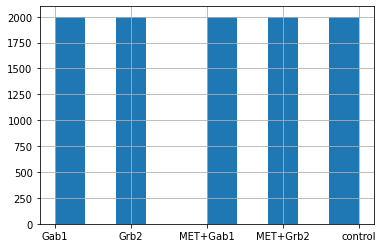

In [3]:
pd.Series(types).hist()

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,labs_by_type,test_size=0.2,random_state=42)

In [5]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8000, 16, 2) (8000,)
(2000, 16, 2) (2000,)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [7]:
#model params
input_dim = X_train.shape[-1]
num_labels = len(np.unique(y_train))
timesteps = X_train.shape[-2]
n_filters = [64,64,32]
kernel_size = 8
strides = 1
pool_size = 8
n_units = [64,8]

optimizer='adam'
#optimizer = Adam(lr=0.01)
#loss = 'categorical_crossentropy' # need one ot encoded labels
loss = 'sparse_categorical_crossentropy' # need label encoded labels
epochs=100
batch_size=256
save_dir='results/tmp'
verbose=1
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [8]:
classifier_model,encoder_model = cm.temporal_classifier(input_dim,num_labels,timesteps,n_filters,kernel_size,strides,pool_size,n_units)
classifier_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
classifier_model.summary()

2022-09-12 10:46:11.970305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            1088      
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            32832     
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 32)            16416     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                        

In [9]:
t0 = time()
history = classifier_model.fit(X_train, y_train,validation_data=(X_test,y_test) , batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=es)
print('Pretraining time: ', time() - t0)

Epoch 1/100
32/32 [==============================] - 7s 61ms/step - loss: 1.6090 - accuracy: 0.2019 - val_loss: 1.6051 - val_accuracy: 0.2250
Epoch 2/100
32/32 [==============================] - 1s 21ms/step - loss: 1.5990 - accuracy: 0.2531 - val_loss: 1.5903 - val_accuracy: 0.2480
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 1.5611 - accuracy: 0.3039 - val_loss: 1.5275 - val_accuracy: 0.3140
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 1.4767 - accuracy: 0.3641 - val_loss: 1.4397 - val_accuracy: 0.3910
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 1.4029 - accuracy: 0.4019 - val_loss: 1.3870 - val_accuracy: 0.4050
Epoch 6/100
32/32 [==============================] - 1s 22ms/step - loss: 1.3285 - accuracy: 0.4514 - val_loss: 1.3608 - val_accuracy: 0.4310
Epoch 7/100
32/32 [==============================] - 1s 23ms/step - loss: 1.2868 - accuracy: 0.4666 - val_loss: 1.3554 - val_accuracy: 0.4275
Epoch 

Train: 0.559, Test: 0.442


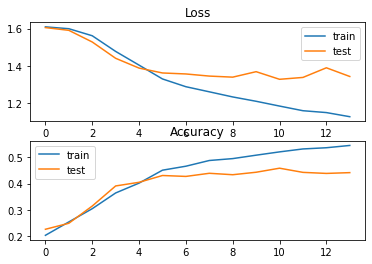

In [10]:
_, train_acc = classifier_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = classifier_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [11]:
y_pred = classifier_model.predict(X_test)
confusion = tf.math.confusion_matrix(
              labels = y_test,      # get trule labels 
              predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
              num_classes=num_labels) 

63/63 [==============================] - 2s 3ms/step


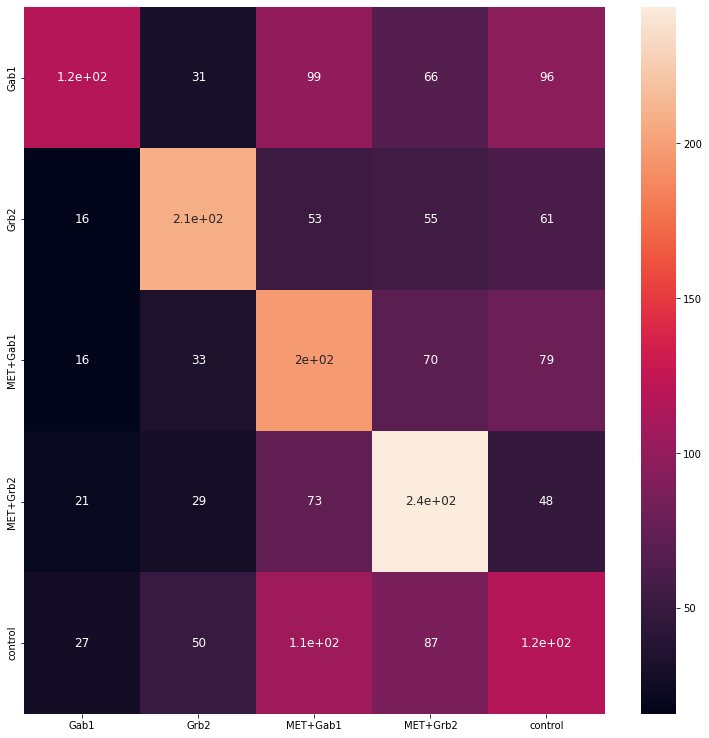

In [12]:
import seaborn as sns 
import pandas as pd 

cm = pd.DataFrame(confusion.numpy(), # use .numpy(), because now confusion is tensor
               le.inverse_transform(range(num_labels)),le.inverse_transform(range(num_labels)))

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

<AxesSubplot:>

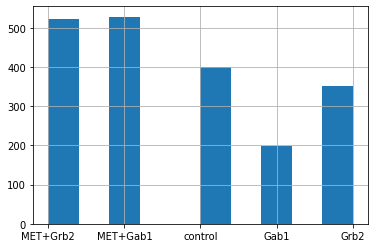

In [13]:
pd.Series(le.inverse_transform(np.argmax(y_pred, axis=1))).hist()